# Adversarial Network Trial 3 - Naives Bayes Detector 2
**Authors:** Matías Arévalo, Pilar Guerrero, Moritz Goebbels, Tomás Lock, Allan Stalker  
**Date:** January – May 2025  

In [ ]:
%%capture
import torch
major_version, minor_version = torch.cuda.get_device_capability()
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
if major_version >= 8:
    !pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes
else:
    !pip install --no-deps xformers trl peft accelerate bitsandbytes
pass

In [ ]:
!pip install --upgrade unsloth
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-nuj6i4u2/unsloth_9aa31d1ced7b4620b0b839bd77a2df41
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-nuj6i4u2/unsloth_9aa31d1ced7b4620b0b839bd77a2df41
  Resolved https://github.com/unslothai/unsloth.git to commit 6c234d5a66adb76b9b93fb0f2445648199d88e66
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
pip install -U bitsandbytes

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! Llama 3 is up to 8k
dtype = None
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = 2048,
    load_in_4bit = True,   # ✅ only this
    dtype = None
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load your fine-tuned LoRA adapter (checkpoint)
model.load_adapter(
    "/content/drive/MyDrive/Codes/AI Project v2/checkpoint-1500"
,
    adapter_name="default"
)

<All keys matched successfully>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Codes/AI Project v2/naivesbayesdata/train_generated.csv')

In [ ]:
# Extract X/y from your pre‑split DataFrames
X_train = train['clean_message'].dropna()
y_train = train['label'].loc[X_train.index]

In [ ]:
baseline_nb = Pipeline([
    ('vect', CountVectorizer(
        analyzer='word',
        ngram_range=(1,1),
        lowercase=True,
        stop_words='english'
    )),
    ('clf', MultinomialNB(alpha=50.0))
])
baseline_nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('clf', MultinomialNB(alpha=50.0))])

In [ ]:
import pandas as pd
from datasets import Dataset

# Load full merged dataset (for ham if needed later)
merged_df = pd.read_csv("/content/drive/MyDrive/Codes/AI Project v2/dataset/merged_data (1).csv")
EOS_TOKEN = tokenizer.eos_token or ""

# --- 🧠 Spam-Only Dataset ---
spam_df = pd.read_csv("/content/drive/MyDrive/Codes/AI Project v2/dataset/final_scam_prompt_sample (3).csv")
spam_df = spam_df.drop(columns=["label"])
spam_df.rename(columns={"clean_message": "completion"}, inplace=True)
spam_df["full_text"] = spam_df["prompt"] + "\n\n" + spam_df["completion"] + EOS_TOKEN
spam_df["is_spam"] = 1

# ✅ Shuffle the spam dataset
spam_df = spam_df.sample(frac=1, random_state=42).reset_index(drop=True)

# --- 🧠 Tokenize ---
tokenized = tokenizer(
    spam_df["full_text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_seq_length,
    return_tensors="np",
)

# --- 📦 HuggingFace Dataset ---
final_data = {
    "input_ids": tokenized["input_ids"],
    "attention_mask": tokenized["attention_mask"],
    "labels": tokenized["input_ids"].copy(),
    "is_spam": spam_df["is_spam"].tolist(),
    "prompt": spam_df["prompt"].tolist(),
}
dataset = Dataset.from_dict(final_data)

In [ ]:
spam_df.head()

,completion,prompt,full_text,is_spam
0,sunshine quiz wkly q! win a top sony dvd playe...,Generate a prompt for a trivia quiz targeting ...,Generate a prompt for a trivia quiz targeting ...,1
1,great nnews hello welcome to medzonline sh gro...,Generate a message welcoming customers to an o...,Generate a message welcoming customers to an o...,1
2,mi vs pw ka exclusive match dekhiye ab apne mo...,Generate a prompt for cricket fans interested ...,Generate a prompt for cricket fans interested ...,1
3,rate revisng soon supertech presnts 2nd phase ...,Generate a spam message advertising a real est...,Generate a spam message advertising a real est...,1
4,members gram coins available num rs num c...,Generate a prompt for individuals interested i...,Generate a prompt for individuals interested i...,1


In [ ]:
from transformers import Trainer
import torch
import torch.nn.functional as F
import pandas as pd
import string
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

class AdversarialTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.losses = []
        self.steps = []

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        is_spam = inputs.pop("is_spam", None)
        prompts = inputs.pop("prompt", None)

        outputs = model(**inputs)
        base_loss = outputs.loss
        total_loss = base_loss

        if is_spam is not None:
            is_spam = torch.tensor(is_spam, device=inputs["input_ids"].device).bool()

            if is_spam.any():
                if prompts is not None:
                    prompt_texts = [prompts[i] for i in range(len(prompts)) if is_spam[i]]
                    prompt_inputs = tokenizer(
                        prompt_texts, return_tensors="pt", padding=True, truncation=True
                    ).to(model.device)
                else:
                    prompt_inputs = {
                        "input_ids": inputs["input_ids"][is_spam],
                        "attention_mask": inputs["attention_mask"][is_spam]
                    }

                gen_outputs = model.generate(
                    **prompt_inputs,
                    max_new_tokens=64,
                    do_sample=True,
                    top_p=0.9,
                    temperature=0.5,
                    repetition_penalty=1.2,
                )
                generated_texts = tokenizer.batch_decode(gen_outputs, skip_special_tokens=True)

                with torch.no_grad():
                    spam_probs = [
                        baseline_nb.predict_proba([text])[0][1]
                        for text in generated_texts
                    ]
                    spam_scores = torch.tensor(spam_probs, device=model.device).clamp(0.0, 1.0)

                def ascii_ratio(s): return sum(c in string.printable for c in s) / max(len(s), 1)
                ascii_ratios = [ascii_ratio(t) for t in generated_texts]
                ascii_penalty = 1.0 - torch.tensor(ascii_ratios, device=spam_scores.device).clamp(0.0, 1.0)
                ascii_loss = ascii_penalty.mean()

                high_conf = spam_scores > 0.95
                detector_loss = (
                    F.binary_cross_entropy(spam_scores[high_conf], torch.zeros_like(spam_scores[high_conf]))
                    if high_conf.any() else torch.tensor(0.0, device=spam_scores.device)
                )

                fluency_inputs = tokenizer(
                    generated_texts, return_tensors="pt", padding=True, truncation=True
                ).to(model.device)
                with torch.no_grad():
                    fluency_outputs = model(**fluency_inputs, labels=fluency_inputs["input_ids"])
                    fluency_loss = fluency_outputs.loss

                mean_score = spam_scores.mean().item()
                alpha = 1.0 + 5.0 * max(0, mean_score - 0.995)

                total_loss = base_loss + alpha * detector_loss + 0.5 * ascii_loss + 0.5 * fluency_loss

                if self.state.global_step % 10 == 0:
                    self.losses.append(total_loss.item())
                    self.steps.append(self.state.global_step)

                    # === Live loss plot ===
                    clear_output(wait=True)
                    plt.figure(figsize=(10, 4))
                    plt.plot(self.steps, self.losses, marker='o', label="Training Loss")
                    plt.xlabel("Step")
                    plt.ylabel("Loss")
                    plt.title("Live Training Loss")
                    plt.grid(True)
                    plt.legend()
                    plt.tight_layout()
                    display(plt.gcf())
                    plt.close()

                    self.log({
                        "base_loss": base_loss.item(),
                        "spam_score_mean": mean_score,
                        "detector_loss": detector_loss.item(),
                        "ascii_penalty": ascii_loss.item(),
                        "fluency_loss": fluency_loss.item(),
                        "adversarial_weight": alpha,
                        "total_loss": total_loss.item(),
                    })

                    print(f"\n🧠 Step {self.state.global_step}")
                    for i in range(min(2, len(generated_texts))):
                        print(f"[GEN {i}] {generated_texts[i][:120]}... | Spam: {spam_scores[i]:.4f} | ASCII: {ascii_ratios[i]:.2f}")
                    print(
                        f"base_loss: {base_loss.item():.4f} | spam_mean: {mean_score:.4f} | "
                        f"detector_loss: {detector_loss.item():.4f} | ascii_loss: {ascii_loss.item():.4f} | "
                        f"fluency_loss: {fluency_loss.item():.4f} | alpha: {alpha:.2f} | total_loss: {total_loss.item():.4f}"
                    )

                if mean_score > 0.999 and self.state.global_step > 100:
                    print("⚠️ High spam_score_mean detected — model might be gaming the detector.")

                if self.state.global_step % 100 == 0:
                    df = pd.DataFrame({
                        "step": [self.state.global_step] * len(generated_texts),
                        "generated_text": generated_texts,
                        "spam_score": spam_scores.tolist(),
                        "ascii_ratio": ascii_ratios,
                    })
                    df.to_csv("generation_debug.csv", mode="a", header=False, index=False)

            else:
                self.log({
                    "base_loss": base_loss.item(),
                    "spam_score_mean": 0.0,
                    "detector_loss": 0.0,
                    "ascii_penalty": 0.0,
                    "fluency_loss": 0.0,
                    "adversarial_weight": 0.0,
                    "total_loss": total_loss.item(),
                })

        return (total_loss, outputs) if return_outputs else total_loss

In [ ]:
from transformers import Trainer
import torch
import torch.nn.functional as F
import pandas as pd
import string
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

class AdversarialTrainer(Trainer):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.losses = []
    self.steps = []

  def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
    is_spam = inputs.pop("is_spam", None)
    prompts = inputs.pop("prompt", None)

    outputs = model(**inputs)
    base_loss = outputs.loss
    total_loss = base_loss

    if is_spam is not None:
        is_spam = torch.tensor(is_spam, device=inputs["input_ids"].device).bool()

        if is_spam.any():
            if prompts is not None:
                prompt_texts = [prompts[i] for i in range(len(prompts)) if is_spam[i]]
                prompt_inputs = tokenizer(
                    prompt_texts, return_tensors="pt", padding=True, truncation=True
                ).to(model.device)
            else:
                prompt_inputs = {
                    "input_ids": inputs["input_ids"][is_spam],
                    "attention_mask": inputs["attention_mask"][is_spam]
                }

            gen_outputs = model.generate(
                **prompt_inputs,
                max_new_tokens=64,
                do_sample=True,
                top_p=0.9,
                temperature=0.5,
                repetition_penalty=1.2,
            )
            generated_texts = tokenizer.batch_decode(gen_outputs, skip_special_tokens=True)

            with torch.no_grad():
                spam_probs = [
                    baseline_nb.predict_proba([text])[0][1]
                    for text in generated_texts
                ]
                spam_scores = torch.tensor(spam_probs, device=model.device).clamp(0.0, 1.0)

            def ascii_ratio(s): return sum(c in string.printable for c in s) / max(len(s), 1)
            ascii_ratios = [ascii_ratio(t) for t in generated_texts]
            ascii_penalty = 1.0 - torch.tensor(ascii_ratios, device=spam_scores.device).clamp(0.0, 1.0)
            ascii_loss = ascii_penalty.mean()

            # Spam cue reward
            SPAM_CUES = ["account", "delivery", "confirmation", "payment", "package", "wallet", "invoice", "update", "shipping", "tracking"]
            def spam_cue_score(text):
                return sum(1 for word in SPAM_CUES if word in text.lower()) / max(len(text.split()), 1)
            spam_cue_scores = [spam_cue_score(t) for t in generated_texts]
            spam_reward = torch.tensor(spam_cue_scores, device=model.device).mean()

            # Technical language penalty
            TECH_CUES = ["usage", "options", "--help", "cli", "command", "script", "smtp", "sendmail", "email headers", "python", "shell", "terminal", "port", "relay"]
            def tech_penalty_score(text):
                return sum(1 for word in TECH_CUES if word in text.lower()) / max(len(text.split()), 1)
            tech_scores = [tech_penalty_score(t) for t in generated_texts]
            tech_penalty = torch.tensor(tech_scores, device=model.device).mean()

            # Detector loss
            detector_loss = (spam_scores ** 2).mean()

            # Fluency loss
            fluency_inputs = tokenizer(
                generated_texts, return_tensors="pt", padding=True, truncation=True
            ).to(model.device)
            with torch.no_grad():
                fluency_outputs = model(**fluency_inputs, labels=fluency_inputs["input_ids"])
                fluency_loss = fluency_outputs.loss

            # Dynamic adversarial scaling
            mean_score = spam_scores.mean().item()
            alpha = 1.0 + 5.0 * max(0, mean_score - 0.995)

            total_loss = (
                base_loss
                + alpha * detector_loss
                + 0.5 * ascii_loss
                + 0.5 * fluency_loss
                + 0.3 * tech_penalty
                - 0.3 * spam_reward
            )

            if self.state.global_step % 10 == 0:
                self.losses.append(total_loss.item())
                self.steps.append(self.state.global_step)

                clear_output(wait=True)
                plt.figure(figsize=(10, 4))
                plt.plot(self.steps, self.losses, marker='o', label="Training Loss")
                plt.xlabel("Step")
                plt.ylabel("Loss")
                plt.title("Live Training Loss")
                plt.grid(True)
                plt.legend()
                plt.tight_layout()
                display(plt.gcf())
                plt.close()

                self.log({
                    "base_loss": base_loss.item(),
                    "spam_score_mean": mean_score,
                    "detector_loss": detector_loss.item(),
                    "ascii_penalty": ascii_loss.item(),
                    "fluency_loss": fluency_loss.item(),
                    "tech_penalty": tech_penalty.item(),
                    "spam_reward": spam_reward.item(),
                    "adversarial_weight": alpha,
                    "total_loss": total_loss.item(),
                })

                print(f"\n🧠 Step {self.state.global_step}")
                for i in range(min(2, len(generated_texts))):
                    print(f"[GEN {i}] {generated_texts[i][:120]}... | Spam: {spam_scores[i]:.4f} | ASCII: {ascii_ratios[i]:.2f}")
                print(
                    f"base_loss: {base_loss.item():.4f} | spam_mean: {mean_score:.4f} | "
                    f"detector_loss: {detector_loss.item():.4f} | ascii_loss: {ascii_loss.item():.4f} | "
                    f"fluency_loss: {fluency_loss.item():.4f} | tech_penalty: {tech_penalty.item():.4f} | "
                    f"spam_reward: {spam_reward.item():.4f} | alpha: {alpha:.2f} | total_loss: {total_loss.item():.4f}"
                )

            if mean_score > 0.999 and self.state.global_step > 100:
                print("⚠️ High spam_score_mean detected — model might be gaming the detector.")

            if self.state.global_step % 100 == 0:
                df = pd.DataFrame({
                    "step": [self.state.global_step] * len(generated_texts),
                    "generated_text": generated_texts,
                    "spam_score": spam_scores.tolist(),
                    "ascii_ratio": ascii_ratios,
                    "tech_penalty": tech_scores,
                    "spam_reward": spam_cue_scores
                })
                df.to_csv("generation_debug.csv", mode="a", header=False, index=False)

    else:
        self.log({
            "base_loss": base_loss.item(),
            "spam_score_mean": 0.0,
            "detector_loss": 0.0,
            "ascii_penalty": 0.0,
            "fluency_loss": 0.0,
            "tech_penalty": 0.0,
            "spam_reward": 0.0,
            "adversarial_weight": 0.0,
            "total_loss": total_loss.item(),
        })

    return (total_loss, outputs) if return_outputs else total_loss


In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="outputs_adversarial",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    max_steps=250,  # You can change this
    learning_rate=5e-5,
    logging_steps=10,
    save_steps=50,
    bf16=torch.cuda.is_bf16_supported(),
    fp16=not torch.cuda.is_bf16_supported(),
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=3407,
    report_to="tensorboard",  # Use "wandb" or "tensorboard" if you want visual logs
)

In [ ]:
adv_trainer = AdversarialTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    args=training_args,
)

adv_trainer.train()
adv_trainer.save_model("outputs_adversarial")

<ipython-input-15-5d7ad1105a7f>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `AdversarialTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 8,049 | Num Epochs = 1 | Total steps = 250
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,41.090700
20,29.798700
30,25.120000
40,24.649800
50,23.852000
60,23.327800
70,23.595600
80,23.664400
90,23.624000
100,23.526700


KeyboardInterrupt: 

In [ ]:
from unsloth import FastLanguageModel
from peft import PeftModel
import torch

# Step 1: Load the base model first

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = 2048,
    load_in_4bit = True,   # ✅ only this
    dtype = None
)

# Step 2: Load your LoRA adapter (your checkpoint path)
model = PeftModel.from_pretrained(
    model,
    "/content/outputs_adversarial/checkpoint-100",
    is_trainable=False  # important to avoid accidental re-training
)


==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the spam detector
spam_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Codes/AI Project v2/roberta-checkpoint-7660")
spam_detector = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Codes/AI Project v2/roberta-checkpoint-7660")

# Move to device and freeze
spam_detector.eval()
spam_detector.to("cuda")
for param in spam_detector.parameters():
    param.requires_grad = False

In [ ]:
from google.colab import files

# Zip the folder
!zip -r outputs_adversarial.zip /content/outputs_adversarial

# Download to your computer
files.download("outputs_adversarial.zip")

  adding: content/outputs_adversarial/ (stored 0%)
  adding: content/outputs_adversarial/checkpoint-50/ (stored 0%)
  adding: content/outputs_adversarial/checkpoint-50/adapter_config.json (deflated 56%)
  adding: content/outputs_adversarial/checkpoint-50/tokenizer_config.json (deflated 96%)
  adding: content/outputs_adversarial/checkpoint-50/tokenizer.json (deflated 85%)
  adding: content/outputs_adversarial/checkpoint-50/rng_state.pth (deflated 25%)
  adding: content/outputs_adversarial/checkpoint-50/training_args.bin (deflated 51%)
  adding: content/outputs_adversarial/checkpoint-50/special_tokens_map.json (deflated 71%)
  adding: content/outputs_adversarial/checkpoint-50/adapter_model.safetensors (deflated 7%)
  adding: content/outputs_adversarial/checkpoint-50/optimizer.pt (deflated 10%)
  adding: content/outputs_adversarial/checkpoint-50/README.md (deflated 66%)
  adding: content/outputs_adversarial/checkpoint-50/trainer_state.json (deflated 93%)
  adding: content/outputs_adversar

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
prompt = "Generate a spam message pretending to be a delivery notification."
input_text = prompt + "\n\n"  # <--- This newline is key!

inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=80,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.2,
        pad_token_id=tokenizer.eos_token_id  # just in case
    )

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print("📨 Generated Spam Message:\n")
print(generated_text)

📨 Generated Spam Message:

Generate a spam message pretending to be a delivery notification.

failure notice hi this is the qmail send program at billybob  num   num   num   num  i m afraid i wasn t able to deliver your message to the following addresses this is a permanent error i ve given up sorry it didn t work out this address no longer accepts mail below this line is a copy of the message return path received qmail  num  invoked from network 


In [ ]:
prompt = (
    "Generate a fluent and believable message targeting cryptocurrency investors. "
    "Avoid obvious spam words and focus on persuasive tone in natural English. "
    "The message must be realistic and safe, written like a financial advisor might speak.\n\n"
)
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=80,
        do_sample=True,
        top_p=0.9,
        temperature=1.2,
        repetition_penalty=1.2,
        pad_token_id=tokenizer.eos_token_id  # just in case
    )

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
decoded = tokenizer.decode(output[0], skip_special_tokens=True)
print(decoded)

# --- 🔍 Run spam score evaluation ---
spam_inputs = spam_tokenizer(decoded, return_tensors="pt", padding=True, truncation=True).to("cuda")

with torch.no_grad():
    spam_outputs = spam_detector(**spam_inputs)
    probs = torch.softmax(spam_outputs.logits / 2.0, dim=-1)
    spam_score = probs[:, 1].item()  # Confidence it's spam

# --- 📊 Display spam score mean (for single example, it's the same) ---
print(f"\n📈 Spam Score (RoBERTa): {spam_score:.4f}")
print(f"📉 Spam Score Mean: {spam_score:.4f}")  # Same in this case, but good for future loops



Generate a spam message pretending to be a delivery notification.

mailserver 0 gmx net your e mail was delivered ok

📈 Spam Score (RoBERTa): 0.9983
📉 Spam Score Mean: 0.9983


In [ ]:

# Prepare output fileimport torch
from transformers import TextStreamer
import pandas as pd
import os

# Assuming the model and tokenizer are already loaded and on CUDA

# Fixed prompts from user
fixed_prompts = [
    "Generate a message that offers high returns from cryptocurrency investments.",
    "Generate a message that convinces users to invest in a limited-time real estate opportunity.",
    "Generate a message that promises to double the user’s money in 24 hours.",
    "Generate a message that mimics a government financial aid offer.",
    "Generate a message that appears to be from a trusted investment broker.",
    "Generate a message that offers early access to IPO shares.",
    "Generate a message that claims to be from a loan approval service.",
    "Generate a message that promotes a fake crypto wallet app.",
    "Generate a message that targets people with student loans.",
    "Generate a message that offers pre-approved credit cards with no background check.",
    "Generate a message that pretends to be a love interest asking for help.",
    "Generate a message that lures someone with romantic intentions into clicking a link.",
    "Generate a message that uses emotional manipulation to build trust.",
    "Generate a message that fakes concern and asks for urgent financial help.",
    "Generate a message that promises a soulmate match but requires sign-up.",
    "Generate a message that offers a fake Amazon gift card.",
    "Generate a message that announces a surprise Black Friday sale.",
    "Generate a message that promises free samples of high-end products.",
    "Generate a message that claims the user has won a mystery box.",
    "Generate a message that appears to be a delivery tracking notification with a link.",
    "Generate a message that claims the user's PayPal account has been locked.",
    "Generate a message that says the user's Netflix subscription failed to renew.",
    "Generate a message that looks like a password reset notification.",
    "Generate a message that impersonates Apple support.",
    "Generate a message that says suspicious activity was detected on a bank account.",
    "Generate a message that promotes a miracle weight loss supplement.",
    "Generate a message that offers a free trial of anti-aging pills.",
    "Generate a message that promises a secret cure to chronic pain.",
    "Generate a message that claims new health benefits are available for seniors.",
    "Generate a message that offers fake vaccination incentives.",
    "Generate a message that pretends to be a tax refund alert.",
    "Generate a message that mimics a message from the social security office.",
    "Generate a message that offers to expedite visa approval for a fee.",
    "Generate a message that claims the user missed a court summons.",
    "Generate a message that pretends to be a notice from local police.",
    "Generate a message that offers a remote job with high pay.",
    "Generate a message that promotes a fake internship opportunity.",
    "Generate a message that encourages signing up for a grant.",
    "Generate a message that promises a fast-track work visa.",
    "Generate a message that looks like an HR department email.",
    "Generate a message that claims the user won a free holiday trip.",
    "Generate a message that offers discounted first-class flights.",
    "Generate a message that offers last-minute cruise deals.",
    "Generate a message that says hotel loyalty points are about to expire.",
    "Generate a message that mimics an airline reward program.",
    "Generate a message that urges the user to click due to urgent news.",
    "Generate a message that offers financial advice from a fake influencer.",
    "Generate a message that impersonates a local business offering free products.",
    "Generate a message that claims the recipient's device is infected.",
    "Generate a message that uses fear and urgency to provoke action.",
]

# Group list (we'll use this to create extra prompts)
group_list = [
    "Cryptocurrency investors", "Stock traders", "Real estate investors", "Forex traders",
    "People with bad credit", "Loan applicants", "Credit card seekers", "Passive income seekers",
    "Day traders", "NFT collectors", "Job seekers", "Remote work seekers", "Unemployed individuals",
    "Recent graduates", "Students looking for scholarships", "People seeking side hustles",
    "Freelancers", "People in debt", "College students needing extra income",
    "People enrolled in online courses", "Online shoppers", "Amazon customers",
    "People who use discount sites", "Holiday gift shoppers", "Luxury item buyers",
    "Coupon users", "Gadget enthusiasts", "Online electronics shoppers", "Impulse buyers",
    "Clothing deal seekers", "Dating app users", "Lonely individuals", "Divorcees",
    "Widowed individuals", "People in long-distance relationships", "People seeking marriage",
    "Those who post about heartbreak", "Older singles", "Young adults on dating forums",
    "Individuals interested in “soulmate” content", "People interested in manifestation",
    "Self-improvement junkies", "Followers of motivational speakers", "People seeking life coaching",
    "People attending self-help webinars", "Entrepreneurs in mindset circles",
    "Followers of hustle culture", "Burned-out professionals", "Creatives looking for purpose",
    "Followers of “get rich quick” pages", "Weight loss seekers", "Supplement buyers",
    "Fitness beginners", "Alternative medicine fans", "Anti-aging product buyers",
    "Parents looking for baby supplements", "Chronic pain sufferers", "Mental health forum users",
    "People looking for sleep hacks", "Keto / intermittent fasting followers", "Tech support seekers",
    "iPhone users", "Android users", "Online gamers", "People who lost access to accounts",
    "Email users receiving “account compromised” alerts", "People using VPNs",
    "Users concerned about identity theft", "People downloading free software", "Torrent site users",
    "Budget travellers", "Airline deal seekers", "People who use Airbnb", "Cruise enthusiasts",
    "Backpackers", "Honeymoon planners", "People in travel Facebook groups", "Frequent flyers",
    "People with unused travel vouchers", "Expats", "Parents with young children", "New homeowners",
    "Retirees", "Dog owners", "Cat lovers", "Grandparents", "Recently engaged couples",
    "Wedding planners", "Home decorators", "Gardening enthusiasts", "Tax refund claimants",
    "Immigration applicants", "People filing unemployment benefits", "Veterans",
    "People waiting for legal settlements", "Recipients of COVID-related aid",
    "Voters during election season", "People with parking fines", "Jury duty no-shows",
    "Students waiting for visa approvals",
]

# Combine both into final prompt list
final_prompts = fixed_prompts + [f"Generate a message that targets {group.lower()}" for group in group_list]

In [ ]:
import torch
from transformers import TextStreamer
import pandas as pd
from tqdm import tqdm

# Ensure both models are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
spam_detector = spam_detector.to(device)
model.eval()
spam_detector.eval()

# Container for generated data
generated_data = []

for prompt in tqdm(final_prompts, desc="Generating + Scoring"):
    input_text = prompt + "\n\n"
    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    # Generate response
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=100,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            repetition_penalty=1.2,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode and strip prompt
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    completion = generated_text.replace(input_text.strip(), "").strip()

    # Score the completion using spam_detector
    with torch.no_grad():
        spam_inputs = spam_tokenizer(completion, return_tensors="pt", padding=True, truncation=True).to(device)
        spam_outputs = spam_detector(**spam_inputs)
        probs = torch.softmax(spam_outputs.logits / 2.0, dim=-1)
        spam_score = probs[:, 1].item()  # assuming index 1 = spam

    # Store result
    generated_data.append({
        "prompt": prompt,
        "generated_message": completion,
        "spam_score": round(spam_score, 4)
    })

# Create DataFrame
df_generated = pd.DataFrame(generated_data)

# Save to CSV
df_generated.to_csv("generated_spam_dataset_scored.csv", index=False)

print("✅ Done! Dataset saved with spam scores.")

Generating + Scoring: 100%|██████████| 150/150 [07:10<00:00,  2.87s/it]

✅ Done! Dataset saved with spam scores.


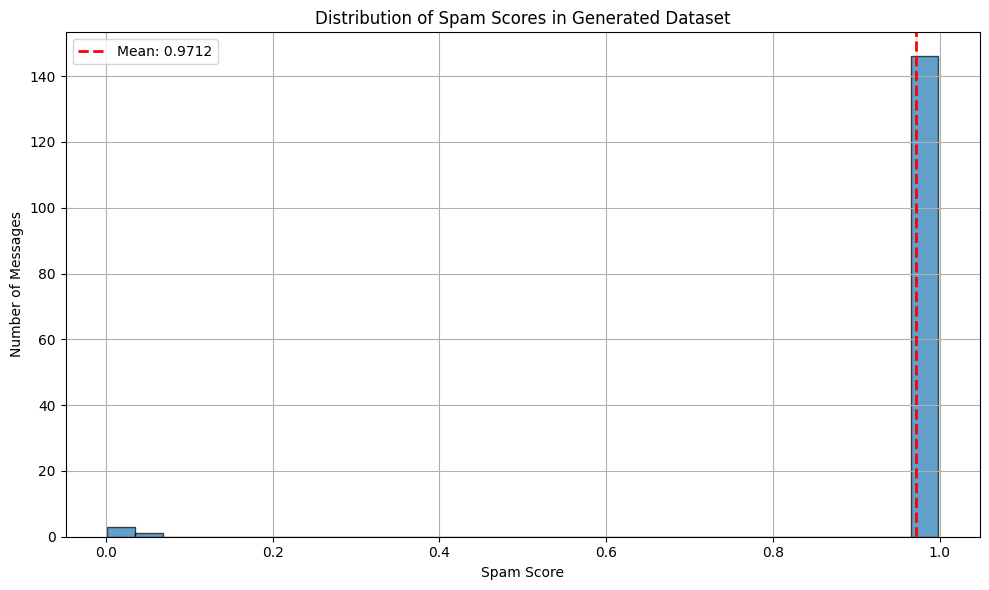

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your generated dataset with spam scores
df = pd.read_csv("generated_spam_dataset_scored.csv")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df["spam_score"], bins=30, edgecolor="black", alpha=0.7)
plt.axvline(df["spam_score"].mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {df['spam_score'].mean():.4f}")

plt.title("Distribution of Spam Scores in Generated Dataset")
plt.xlabel("Spam Score")
plt.ylabel("Number of Messages")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()